<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/iEEG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
sns.set()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
working_path = Path('/content/drive/MyDrive/CoganLab')

In [21]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_all.csv'),
    index_col=None
)

# Preprocessing

In [22]:
ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [23]:
ieeg.isnull().sum()

block                       0
ProbeType                   0
ProbeTypeName               0
StimlusCategory             0
ReactionTime                0
KeyCode                     0
Resp                        0
RespCorrect                 0
Omission                  160
stimulusAudioStart          0
stimulusAlignedTrigger      0
probeAudioStart             0
probeAlignedTrigger         0
TriggerValue                0
stimulusSounds_idx          0
stimulusSounds_name         0
ProbeCategory               0
probeSound_idx              0
probeSound_name             0
Trial                       0
Subject                     0
ListenCueTime             953
MaintenancePeriodTime     953
ProbeCueTime              953
dtype: int64

In [24]:
ieeg.shape

(4820, 24)

In [25]:
ieeg_subset = ieeg[[
                 'Trial', 'Subject', 'block', 'ProbeType', 'probeSound_idx',
                 'ProbeTypeName', 'StimlusCategory', 'ReactionTime', 'KeyCode',
                 'Resp', 'RespCorrect', 'Omission', 'ProbeCategory',
                  'stimulusSounds_idx'                 
]]

In [26]:
ieeg_subset.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,Low Words,[[29 25 30]]
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,High Words,[[ 2 5 8 4 7 10 3]]
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,High Non-Words,[[19 14 18 16 20 15 17]]
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,Low Words,[[10 2 7 9 1 8 6 5 4]]
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,High Words,"[30, 24, 25, 29, 21]"


Checking for accuracy of subjects 

In [27]:
# check if any of the subjects is less than 75 % accurate
checkset = ieeg_subset.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
(checkset < 0.75).any()

RespCorrect    True
dtype: bool

In [28]:
options_drop = checkset[checkset['RespCorrect'] < 0.75].index
checkset = checkset.reset_index()

print('The subjects with accuracy less than 75 %')
print(options_drop)
x = []
for i in checkset.Subject.values:
  for j in options_drop:
    if i == j:
      x.append(checkset.loc[checkset['Subject'] == i][['RespCorrect']].values[0][0])
print(x)  

The subjects with accuracy less than 75 %
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70'], dtype='object', name='Subject')
[0.70625, 0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.71875]


In [29]:
# drop the subjects who are not 75 % accurate
ieeg_short = ieeg_subset.copy()
for i in options_drop:
  ieeg_short = ieeg_short[ieeg_short['Subject'] != i]

In [30]:
# we end up with 23 subjects
len(ieeg_short.Subject.unique())

23

Cleaning 'No response' trials

In [31]:
ieeg_short[ieeg_short['Omission'] == 'No Response']

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx
9,9,D23,1,2,39,in_sequence,Low Non-words,2.502478,[[37 39 32 27]],No Response,0,No Response,Low Non-words,[[32 37 31 39 40 35 33 38 36]]
19,19,D23,1,1,40,out_of_sequence,High Non-Words,2.502283,[[37 39 32 27]],No Response,0,No Response,Low Non-Words,[[17 19 18 13 15 12 16]]
26,26,D23,1,1,33,out_of_sequence,High Non-Words,2.502340,[[37 39 32 27]],No Response,0,No Response,Low Non-Words,[[13 18 14]]
32,32,D23,2,2,25,in_sequence,Low Words,2.502395,[[37 39 32 27]],No Response,0,No Response,Low Words,[[30 22 25 29 21 23 24 28 27]]
97,97,D23,4,1,36,out_of_sequence,High Non-Words,2.502652,[[37 39 32 27]],No Response,0,No Response,Low Non-Words,[[16 17 18]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665,5,D71,1,2,5,in_sequence,High Words,2.502103,"[114, 115, 66, 10, 27]",No Response,0,No Response,High Words,[[10 5 7 1 3 8 6 9 2]]
4691,31,D71,1,2,35,in_sequence,Low Non-words,2.502073,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-words,[[34 39 31 35 38 36 37 33 40]]
4727,67,D71,3,1,8,out_of_sequence,Low Words,2.502108,"[114, 115, 66, 10, 27]",No Response,0,No Response,High Words,[[28 21 23 24 29 26 30 22 25]]
4728,68,D71,3,1,24,out_of_sequence,High Words,0.016217,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[9, 10, 5, 1, 2]"


In [32]:
# deleting all the trials with no responses
ieeg_clean = ieeg_short[ieeg_short['Resp'] != 'No Response']

In [33]:
ieeg_clean[ieeg_clean['Omission'] != 'Responded']
# let's keep these NaNs since all the other information is there     

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx
160,0,D26,1,2,22,in_sequence,Low Words,1.241577,37,Yes,1,NaN,Low Words,[[23 24 25 27 22 21 26 28 29]]
161,1,D26,1,2,35,in_sequence,Low Non-words,1.363980,37,Yes,1,NaN,Low Non-words,[[39 35 37]]
162,2,D26,1,2,28,in_sequence,Low Words,1.246385,37,Yes,1,NaN,Low Words,[[22 27 28]]
163,3,D26,1,1,37,out_of_sequence,Low Non-words,1.239119,39,No,1,NaN,Low Non-Words,[[38 36 32]]
164,4,D26,1,2,26,in_sequence,Low Words,0.944782,37,Yes,1,NaN,Low Words,[[26 21 29]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,155,D26,5,1,32,out_of_sequence,High Non-Words,0.707880,39,No,1,NaN,Low Non-Words,[[20 14 16 19 18 11 13 15 17]]
316,156,D26,5,1,37,out_of_sequence,High Non-Words,0.759770,39,No,1,NaN,Low Non-Words,[[17 14 15 18 13 19 11]]
317,157,D26,5,2,25,in_sequence,Low Words,0.842519,37,Yes,1,NaN,Low Words,[[22 23 21 25 30 26 27]]
318,158,D26,5,1,11,out_of_sequence,Low Non-words,0.964899,39,No,1,NaN,High Non-Words,"[37, 38, 33, 32, 40]"


In [34]:
print(ieeg_clean[ieeg_clean['Omission'] != 'Responded'].Subject.unique())

['D26']


Creating additional variables 

In [35]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in ieeg_clean.ProbeCategory.values:
  new_probe.append(i.lower())
ieeg_clean['ProbeCategory'] = new_probe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
# making values in df more 'handy'
whole_list = ieeg_clean['stimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  new_sound_idx.append(
      [int(s) for s in re.findall(r'\b\d+\b', i)]
  )
ieeg_clean['stimulusSounds_idx'] = new_sound_idx # substitute string type to list with numbers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[3, 7, 9, 5]


In [38]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = ieeg_clean['probeSound_idx'].values
in_out = ieeg_clean['ProbeTypeName'].values
for i in range(0, len(ind)):
  if in_out[i] == 'in_sequence': # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 'out_of_sequence':
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [39]:
length = []
for i in ieeg_clean.stimulusSounds_idx:
  length.append(len(i))

In [40]:
ieeg_clean['Position'] = positions
ieeg_clean['Length'] = length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Dealing with reaction time 

In [41]:
ieeg_clean.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[29, 25, 30]",1,3
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5


In [42]:
rt = ieeg_clean.ReactionTime.values
ieeg_clean['stdRT'] = (rt -rt.mean())/rt.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


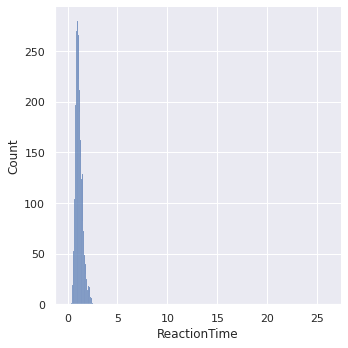

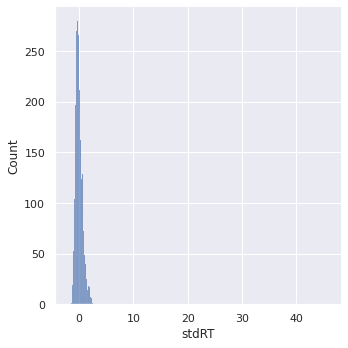

In [43]:
sns.displot(ieeg_clean['ReactionTime'])
#pl.xlim([0, 3]);
sns.displot(ieeg_clean['stdRT']);

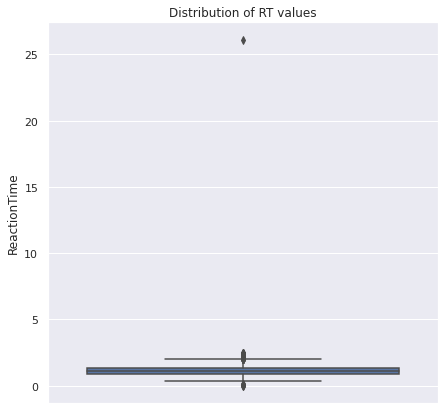

In [44]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=ieeg_clean)
pl.title("Distribution of RT values");

In [45]:
# check for outliers outside 
ieeg_no_outliers = ieeg_clean.copy()
q75 = np.percentile(ieeg_no_outliers['ReactionTime'], 75)
q25 = np.percentile(ieeg_no_outliers['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
for value in ieeg_no_outliers['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
  elif value > upper:
    col_new.append(np.nan)
  else:
    col_new.append(value)
ieeg_no_outliers['ReactionTime'] = col_new

In [46]:
ieeg_no_outliers[ieeg_no_outliers['ReactionTime'].isna()].Subject.unique()

array(['D23', 'D26', 'D27', 'D28', 'D29', 'D31', 'D36', 'D38', 'D39',
       'D41', 'D42', 'D47', 'D48', 'D53', 'D55', 'D57', 'D63', 'D68',
       'D69'], dtype=object)

In [47]:
print(ieeg_no_outliers.isnull().sum()['ReactionTime'])
# drop outliers
ieeg_no_outliers = ieeg_no_outliers.dropna()
print(ieeg_no_outliers.isnull().sum()['ReactionTime'])

103
0


In [48]:
# redo standardization with new values 
rt = ieeg_no_outliers.ReactionTime.values
ieeg_no_outliers['stdRT'] = (rt - rt.mean())/rt.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


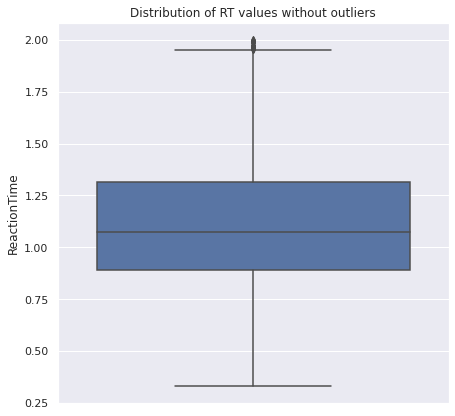

In [49]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=ieeg_no_outliers)
pl.title("Distribution of RT values without outliers");

<Figure size 1440x720 with 0 Axes>

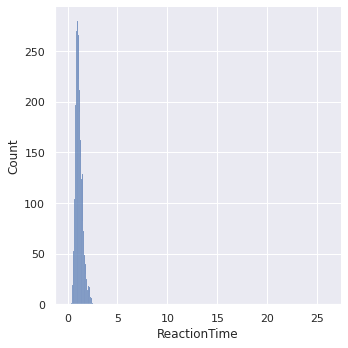

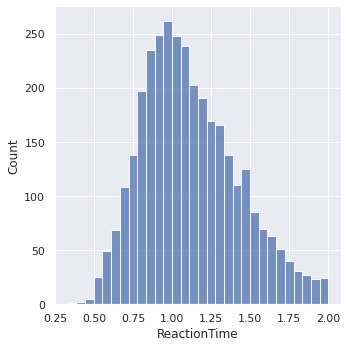

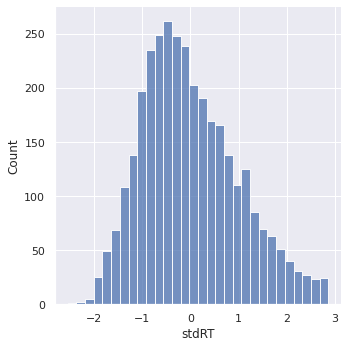

In [50]:
# upper plot - with outliers, lower plot - without
pl.figure(figsize = (20, 10))
sns.displot(ieeg_clean['ReactionTime']);
sns.displot(ieeg_no_outliers['ReactionTime']);
sns.displot(ieeg_no_outliers['stdRT']);

In [51]:
ieeg_no_outliers['ReactionTime'].mean()

1.1172519450611698

Creating columns for dummy coding of lexical and phono variables 

In [52]:
lex = []
phon = []
for i in ieeg_no_outliers.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in ieeg_no_outliers.ProbeCategory.values:
  if 'low' in i: # high = 0 low = 1 
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

3343
3343


In [53]:
ieeg_no_outliers['Lex'] = lex
ieeg_no_outliers['Phono'] = phon

There are two datasets now: ieeg_short - with outliers in RT, ieeg_no_outliers - without

## Plotting the accuracy across conditions

In [54]:
ieeg_no_outliers.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length,stdRT,Lex,Phono
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[29, 25, 30]",1,3,-0.842083,1,1
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7,0.720888,1,0
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7,-0.232119,0,0
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9,1.231184,1,1
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5,1.823783,1,0


In [55]:
only_match = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
only_mismatch = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

In [56]:
ieeg_no_outliers.groupby(['ProbeType'])[['RespCorrect']].mean()

,RespCorrect
ProbeType,
1,0.846719
2,0.876190


In [57]:
ss = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1][['ProbeCategory', 'StimlusCategory']]

In [58]:
new_p = []
new_s = []
for i in ss.ProbeCategory.values:
  new_p.append(i.lower())
for i in ss.StimlusCategory.values:
  new_s.append(i.lower())
print(len(new_p))
print(len(new_s))

1768
1768


In [59]:
ss['ProbeCategory'] = new_p
ss['StimlusCategory'] = new_s

In [60]:
index = 0
check = []
for i in range(0, ss.shape[0]):
  if 'non-words' in new_p[i]:
    if 'non-words' in new_s[i]:
      index += 1 
    else:
      index += 1
      check.append(i)
  else:
    if 'non-words' in new_s[i]:
      index += 1
      check.append(i)
    else:
      index += 1
print(index)
print(check)

1768
[]


**General plots**

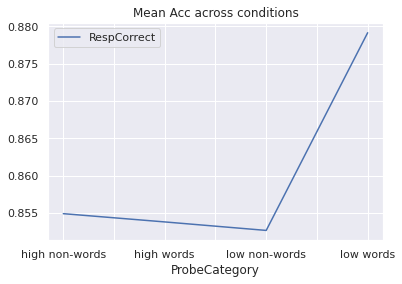

In [61]:
ieeg_no_outliers.groupby(['ProbeCategory'])['RespCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across conditions'
    );

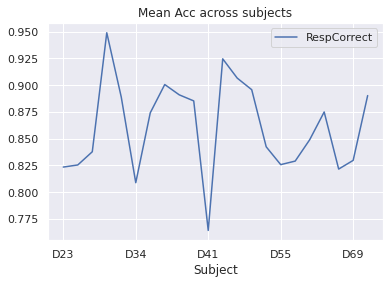

In [62]:
ieeg_no_outliers.groupby(['Subject'])['RespCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across subjects'
    );

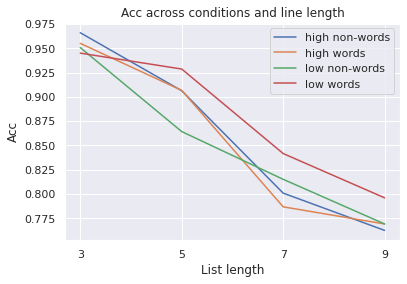

In [63]:
# ALL TOGETHER
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length');  

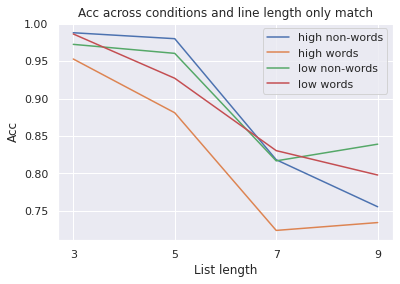

In [64]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match');  

In [65]:
only_match.groupby(['ProbeCategory'])[['RespCorrect']].mean()

,RespCorrect
ProbeCategory,
high non-words,0.882979
high words,0.834783
low non-words,0.898760
low words,0.878378


In [66]:
only_mismatch.groupby(['ProbeCategory'])[['RespCorrect']].mean()

,RespCorrect
ProbeCategory,
high non-words,0.828283
high words,0.869159
low non-words,0.798544
low words,0.879699


In [67]:
only_match.groupby(['Phono'])[['RespCorrect']].mean()

,RespCorrect
Phono,
0,0.859917
1,0.889930


In [68]:
only_mismatch.groupby(['Phono'])[['RespCorrect']].mean()

,RespCorrect
Phono,
0,0.849515
1,0.844280


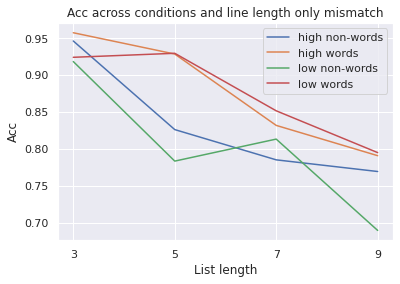

In [69]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch');  

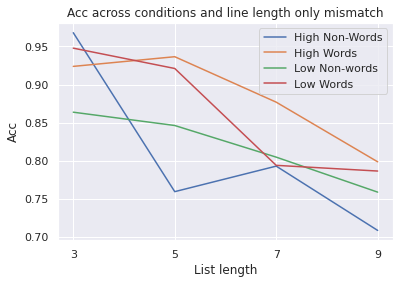

In [70]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = only_mismatch.groupby(['StimlusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimlusCategory.unique():
  x = subset[subset['StimlusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimlusCategory.unique())
pl.title('Acc across conditions and line length only mismatch');  

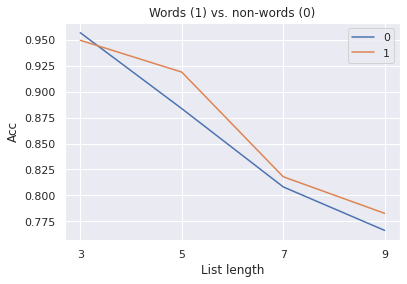

In [71]:
# W VS. NW FOR BOTH MATCH AND MISMATCH
pl.figure()
words_nonwords = ieeg_no_outliers.groupby(['Lex', 'Length'])[['RespCorrect']].mean(). reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words (1) vs. non-words (0)');  

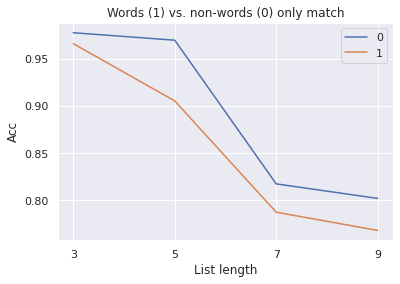

In [72]:
# W VS. NW WHEN MATCH
pl.figure()
words_nonwords = only_match.groupby(['Lex', 'Length'])[['RespCorrect']].mean(). reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words (1) vs. non-words (0) only match'); 

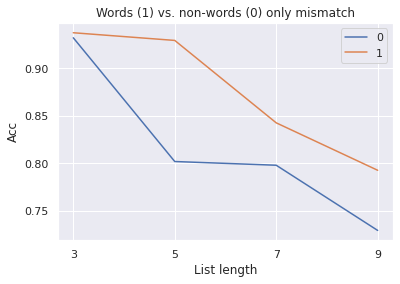

In [73]:
# W VS. NW WHEN MISMATCH
pl.figure()
words_nonwords = only_mismatch.groupby(['Lex', 'Length'])[['RespCorrect']].mean(). reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words (1) vs. non-words (0) only mismatch'); 

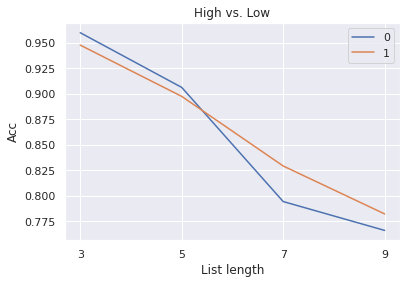

In [74]:
# H VS LOW FOR BOTH MATCH AND MISMATCH
pl.figure()
high_low = ieeg_no_outliers.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low'); 

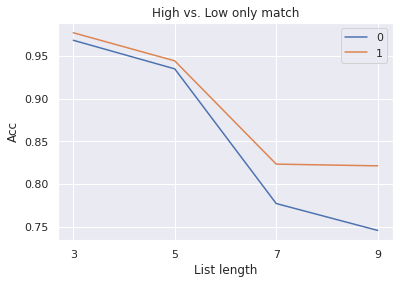

In [75]:
# H VS LOW WHEN MATCH
pl.figure()
high_low = only_match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low only match'); 

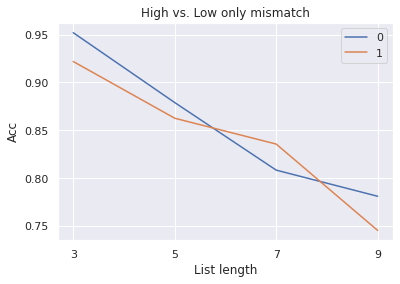

In [76]:
# H VS LOW WHEN MISMATCH
pl.figure()
high_low = only_mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low only mismatch'); 

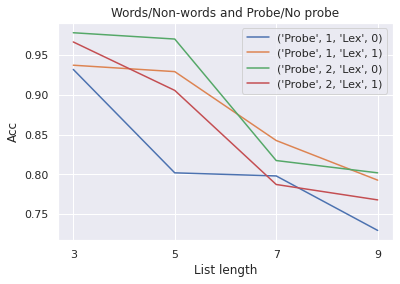

In [77]:
# probe type 2 = in seq, 1 = out of seq
probe_words = ieeg_no_outliers.groupby(['ProbeType', 'Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in probe_words.ProbeType.unique():
  for j in probe_words.Lex.unique():
    x = probe_words[(probe_words['ProbeType'] == i) & (probe_words['Lex'] == j)]
    pl.plot(x.Length, x.RespCorrect, label = ('Probe', i, 'Lex', j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words/Non-words and Probe/No probe');

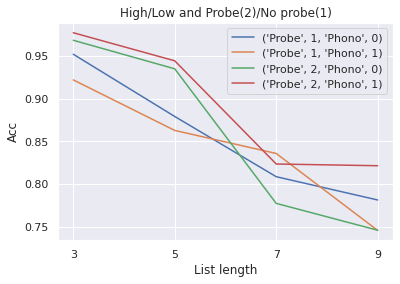

In [78]:
probe_neigh = ieeg_no_outliers.groupby(['ProbeType', 'Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in probe_neigh.ProbeType.unique():
  for j in probe_neigh.Phono.unique():
    x = probe_neigh[(probe_neigh['ProbeType'] == i) & (probe_neigh['Phono'] == j)]
    pl.plot(x.Length, x.RespCorrect, label = ('Probe', i, 'Phono', j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High/Low and Probe(2)/No probe(1)');

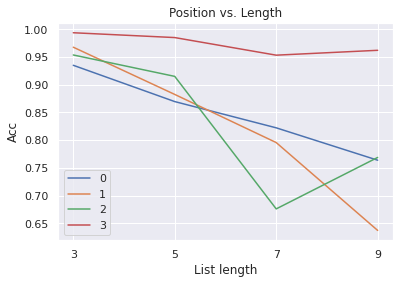

In [79]:
subset = ieeg_no_outliers.groupby(['Position', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Position.unique():
  x = subset[subset['Position'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.Position.unique())
pl.title('Position vs. Length');

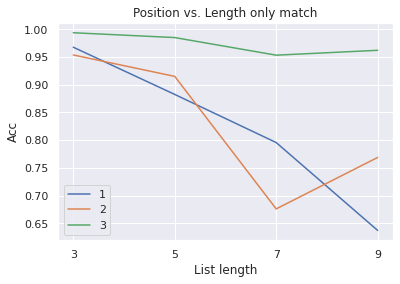

In [80]:
subset = only_match.groupby(['Position', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Position.unique():
  x = subset[subset['Position'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.Position.unique())
pl.title('Position vs. Length only match');

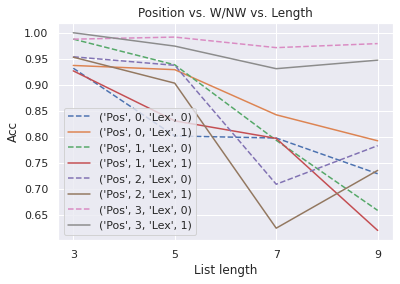

In [81]:
pos_words = ieeg_no_outliers.groupby(['Position', 'Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in pos_words.Position.unique():
  for j in pos_words.Lex.unique():
    x = pos_words[(pos_words['Position'] == i) & (pos_words['Lex'] == j)]
    if j == 0:
      pl.plot(x.Length, x.RespCorrect, '--', label = ('Pos', i, 'Lex', j))
    elif j == 1:
      pl.plot(x.Length, x.RespCorrect, label = ('Pos', i, 'Lex', j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Position vs. W/NW vs. Length');

## Plotting accuracy distributions per subject

In [82]:
ieeg_no_outliers.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length,stdRT,Lex,Phono
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[29, 25, 30]",1,3,-0.842083,1,1
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7,0.720888,1,0
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7,-0.232119,0,0
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9,1.231184,1,1
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5,1.823783,1,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


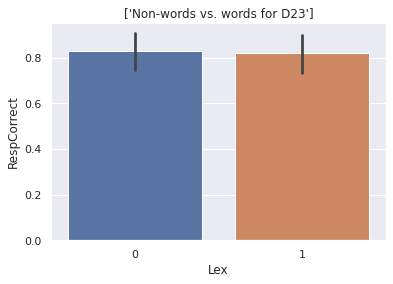

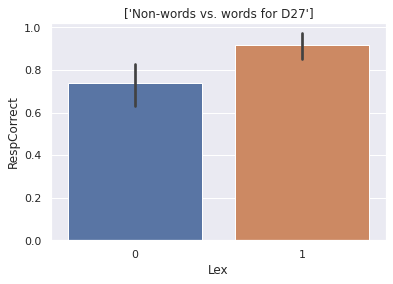

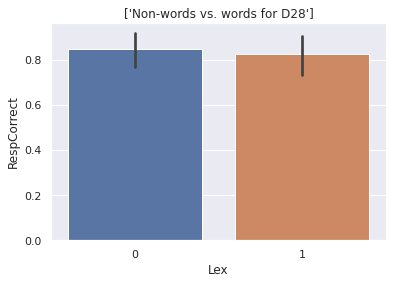

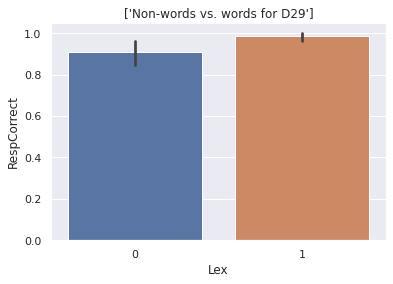

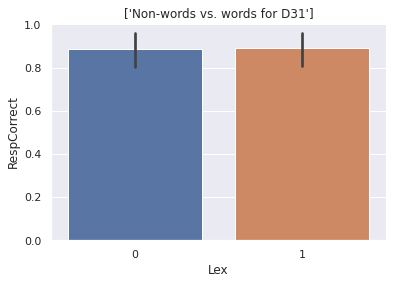

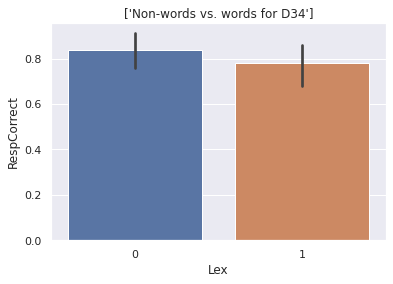

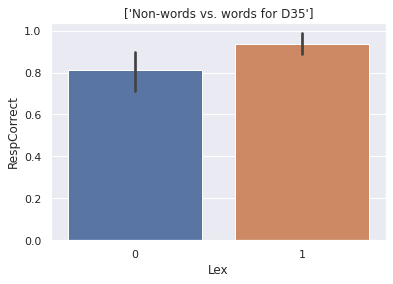

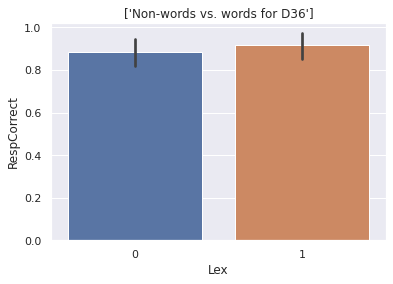

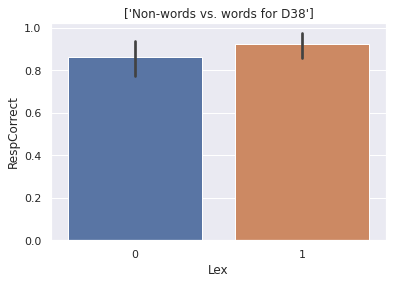

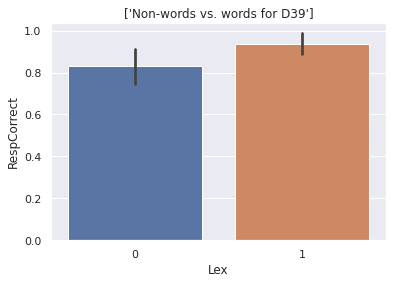

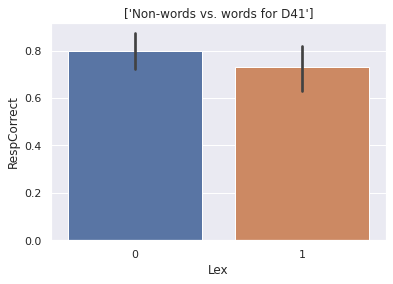

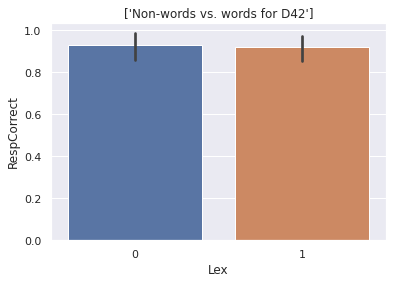

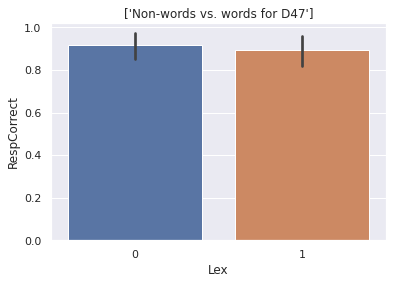

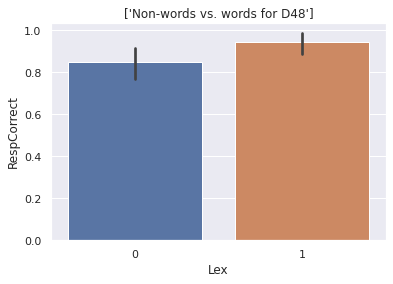

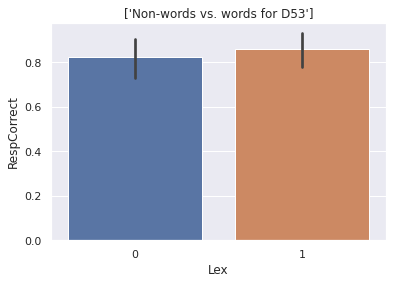

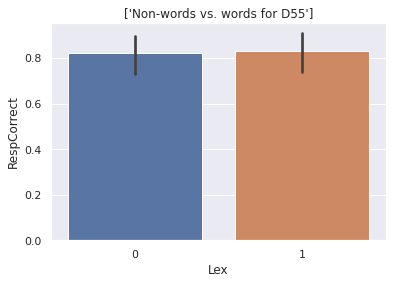

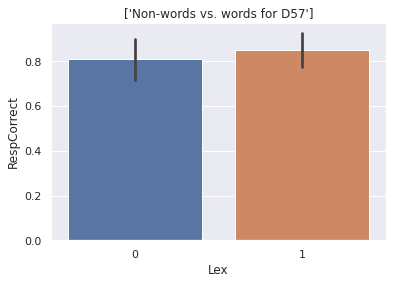

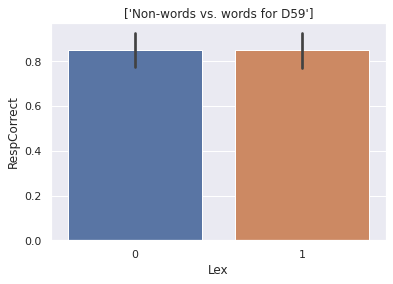

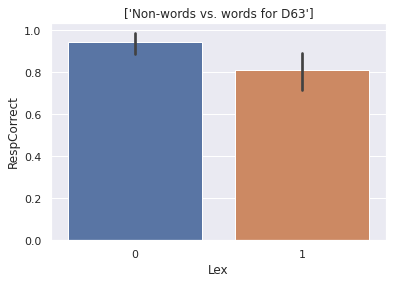

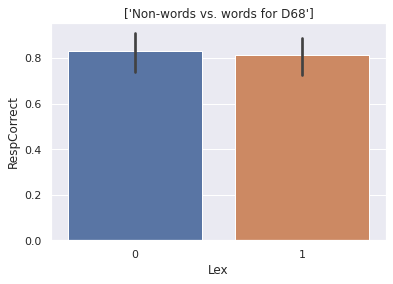

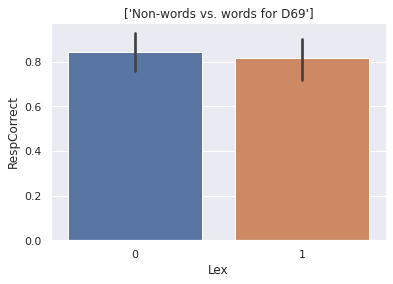

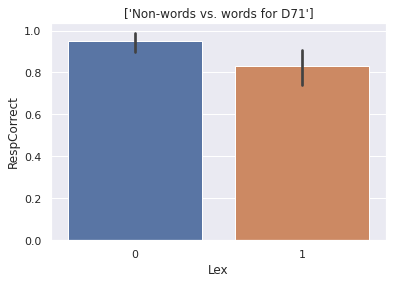

In [83]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.barplot(x = 'Lex', y = 'RespCorrect', data = subset,
              estimator = lambda x: sum(x)/len(x));
  pl.title('Non-words vs. words for ' + subset.Subject.unique());

Paired t-test

In [84]:
sample = ieeg_no_outliers[ieeg_no_outliers['Subject'] == 'D27']
sample = sample[[
        'Lex', 'RespCorrect'
]]

In [85]:
x = sample[sample['Lex'] == 1]
y = sample[sample['Lex'] == 0]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 3.00231574]), pvalue=array([0.        , 0.00322958]))

Plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


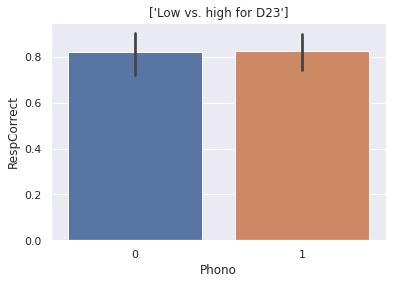

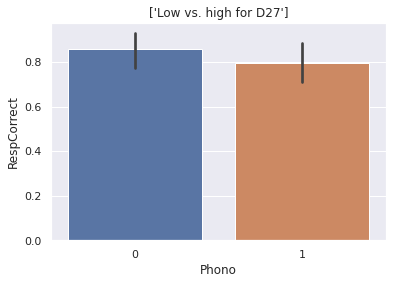

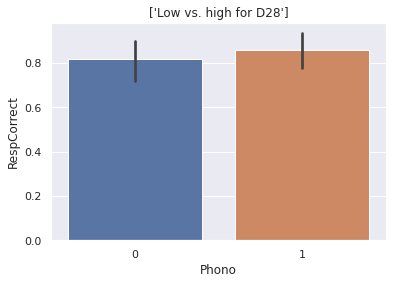

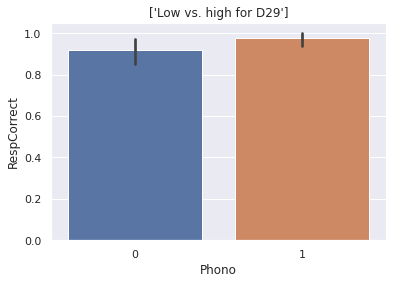

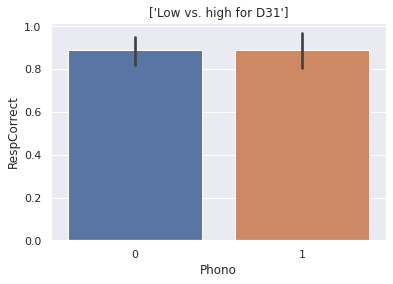

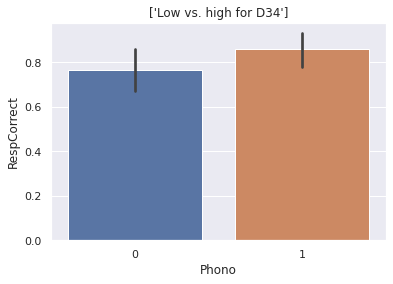

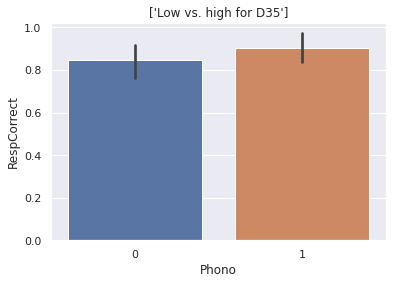

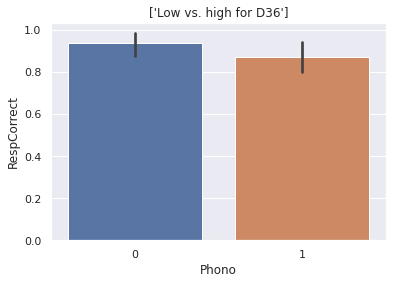

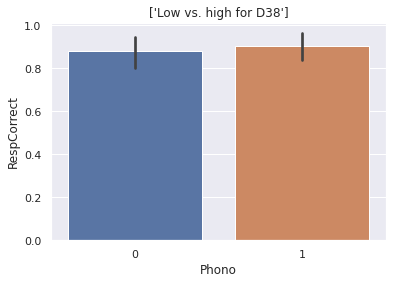

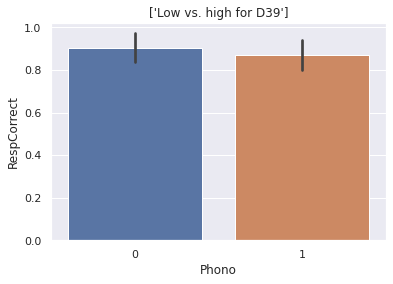

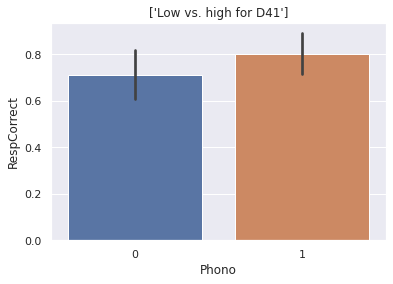

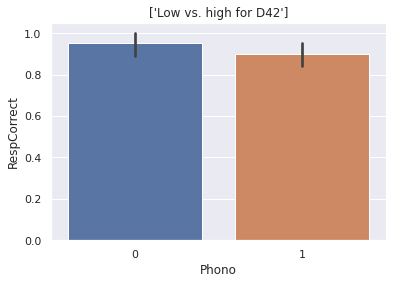

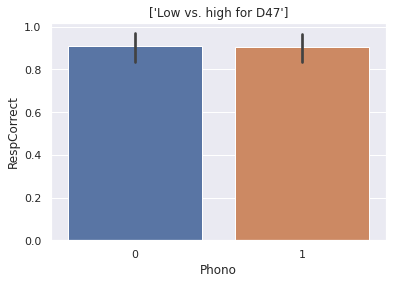

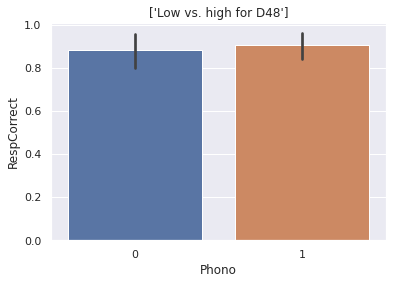

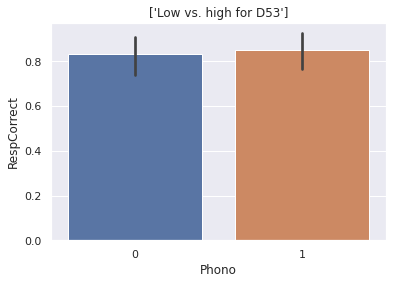

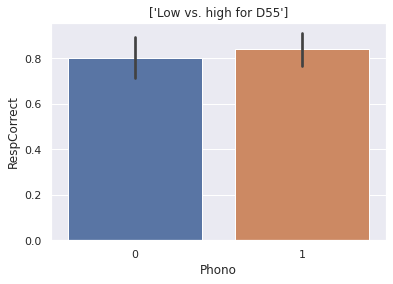

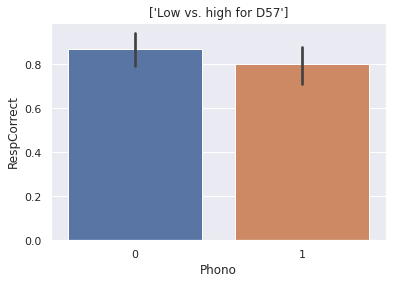

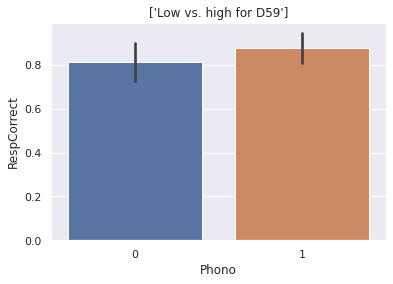

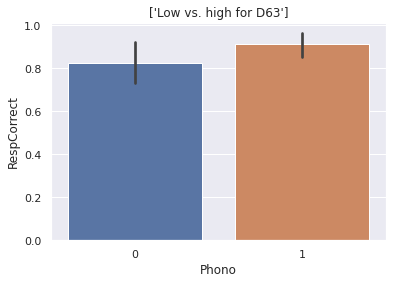

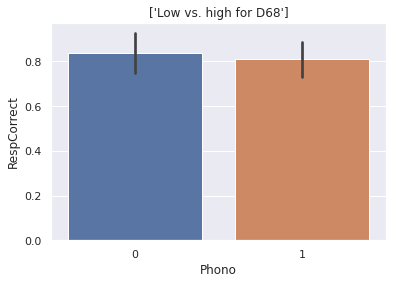

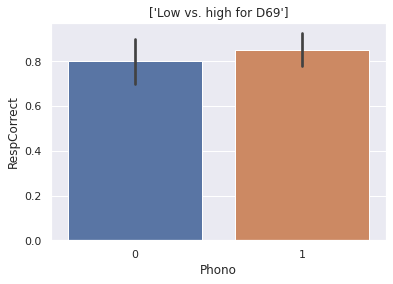

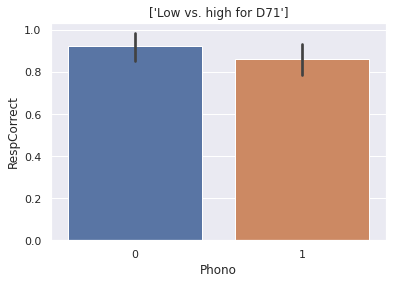

In [86]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.barplot(x = 'Phono', y = 'RespCorrect', data = subset,
              estimator = lambda x: sum(x)/len(x));
  pl.title('Low vs. high for ' + subset.Subject.unique());

Check for significance

In [87]:
sample = ieeg_no_outliers[ieeg_no_outliers['Subject'] == 'D36']
sample = sample[[
                 'Phono', 'RespCorrect'
]]

In [88]:
x = sample[sample['Phono'] == 1]
y = sample[sample['Phono'] == 0]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([        inf, -1.41028348]), pvalue=array([0.       , 0.1605443]))

Plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


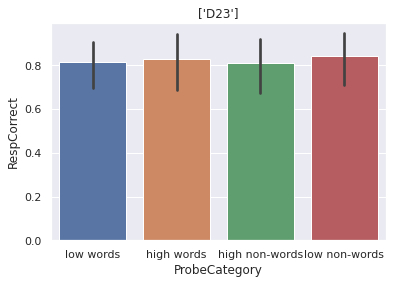

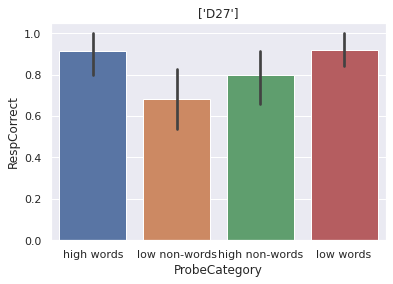

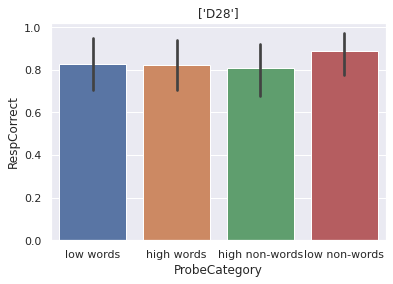

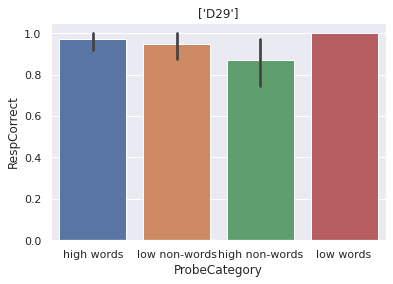

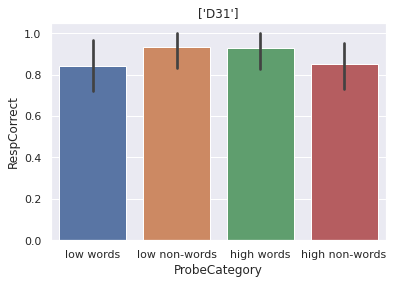

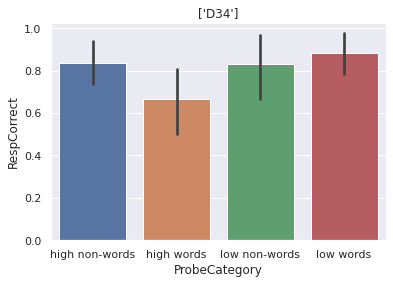

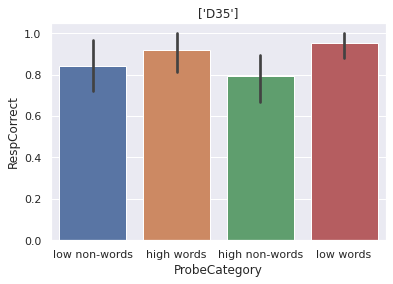

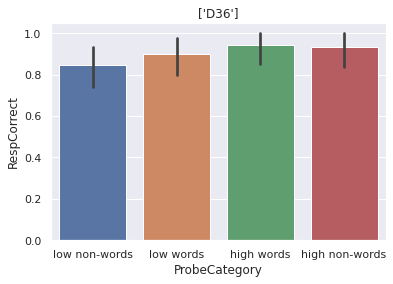

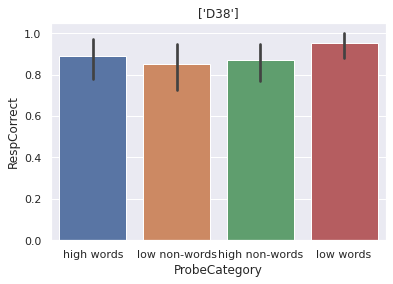

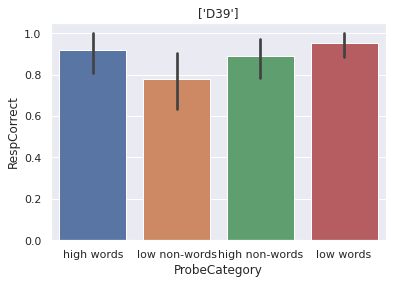

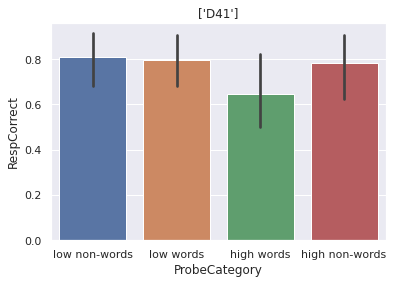

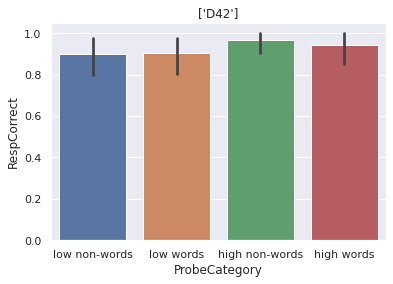

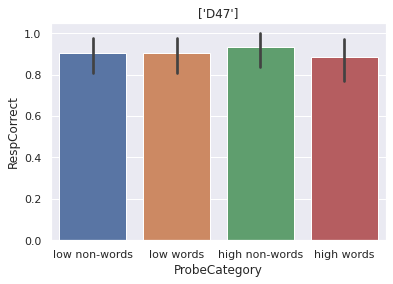

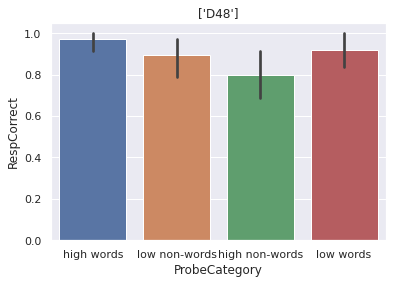

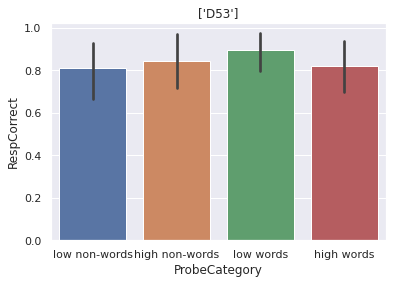

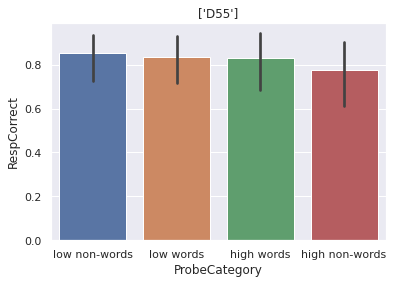

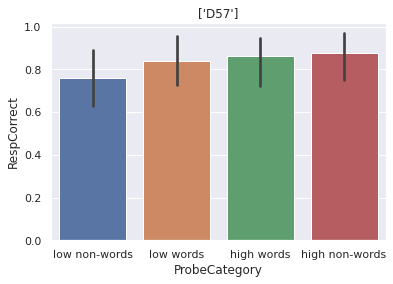

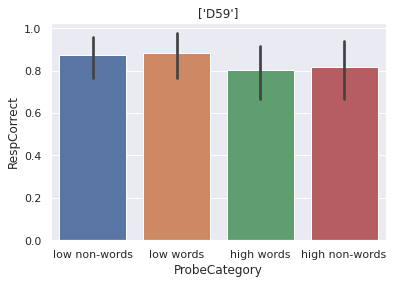

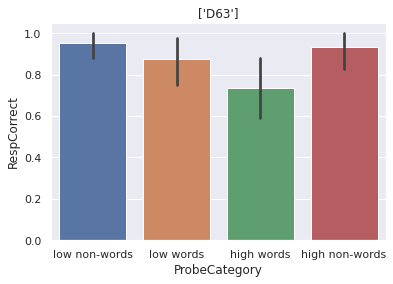

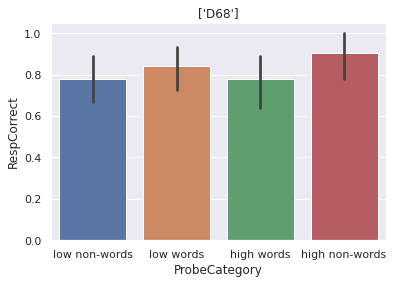

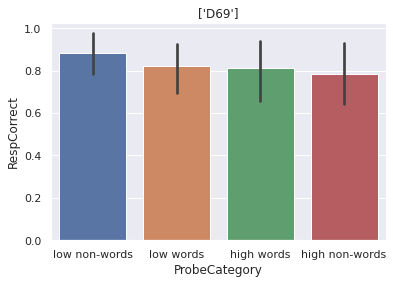

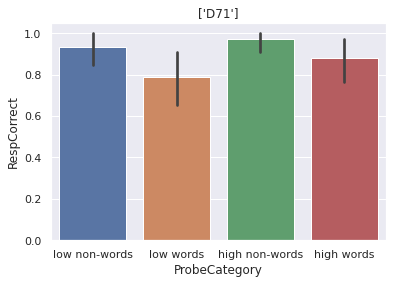

In [89]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'ProbeCategory', y = 'RespCorrect', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title(subset.Subject.unique());

In [90]:
sample = ieeg_no_outliers[ieeg_no_outliers['Subject'] == 'D71']
sample = sample[[
                 'ProbeCategory', 'RespCorrect', 'ProbeType'
]]

In [91]:
x = sample[sample['ProbeCategory'] == 'low words']['RespCorrect'].values
y = sample[sample['ProbeCategory'] == 'low non-words']['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.9492558350445692, pvalue=0.05532702570890543)

In [92]:
x = sample[sample['ProbeCategory'] == 'high words']['RespCorrect'].values
y = sample[sample['ProbeCategory'] == 'high non-words']['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.3701269466303925, pvalue=0.17669261080279886)

In [93]:
x = sample[sample['ProbeCategory'] == 'high words']['RespCorrect'].values
y = sample[sample['ProbeCategory'] == 'low words']['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=1.0888221302269196, pvalue=0.2797189144843813)

In [94]:
x = sample[sample['ProbeCategory'] == 'high non-words']['RespCorrect'].values
y = sample[sample['ProbeCategory'] == 'low non-words']['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.7529469661657905, pvalue=0.4538149560275353)

In [95]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.501714004388507, pvalue=0.15032319933509025)

In [96]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.4045545637924124, pvalue=0.16688160088867024)

In [97]:
x = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.6470870814592462, pvalue=0.5238899129300011)

In [98]:
x = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.4529663145135572, pvalue=0.1625499990297272)

In [99]:
x = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.15384615384615355, pvalue=0.8787188838193977)

In [100]:
x = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.0000000000000007, pvalue=0.3298768009211247)

In [101]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 2)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.9013878188659971, pvalue=0.37616874472419914)

In [102]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 1)]['RespCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.7302681074014575, pvalue=0.46894084506643785)

## Plotting the RT across conditions

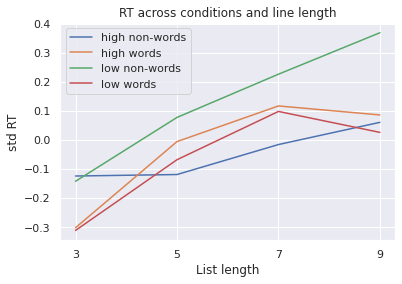

In [103]:
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('std RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length'); 

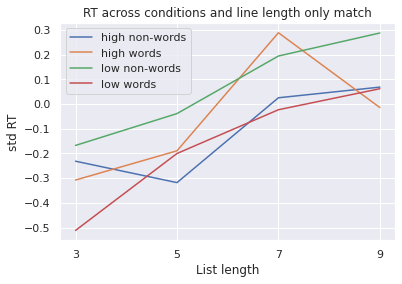

In [104]:
subset = only_match.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('std RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length only match'); 

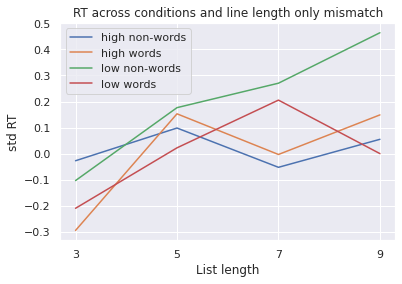

In [105]:
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('std RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length only mismatch'); 

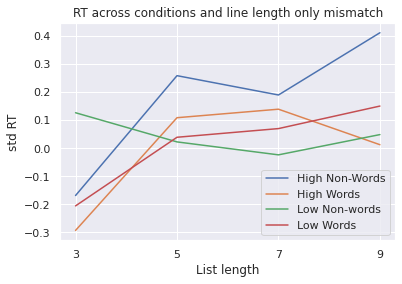

In [106]:
subset = only_mismatch.groupby(['StimlusCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.StimlusCategory.unique():
  x = subset[subset['StimlusCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('std RT')
pl.legend(subset.StimlusCategory.unique())
pl.title('RT across conditions and line length only mismatch'); 

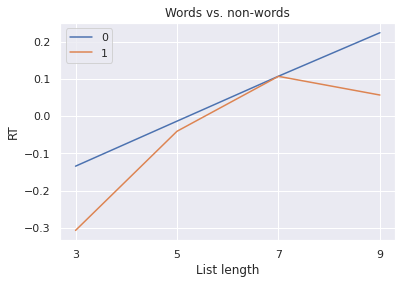

In [107]:
pl.figure()
words_nonwords = ieeg_no_outliers.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words');  

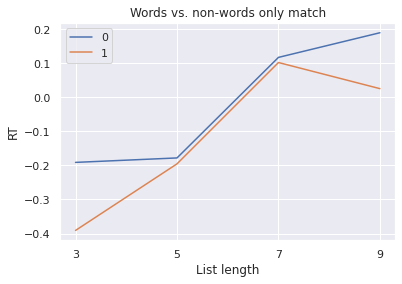

In [108]:
pl.figure()
words_nonwords = only_match.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only match');  

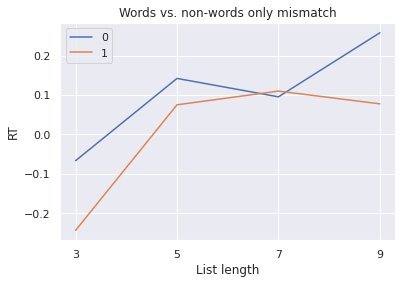

In [109]:
pl.figure()
words_nonwords = only_mismatch.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only mismatch');  

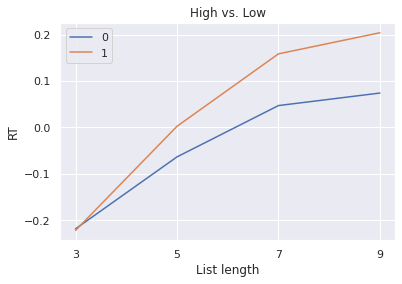

In [110]:
pl.figure()
high_low = ieeg_no_outliers.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low');  

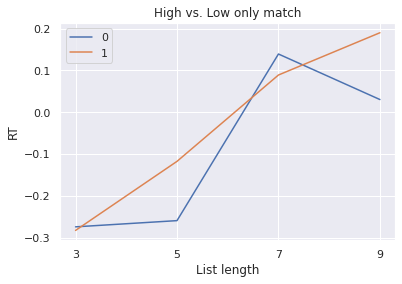

In [111]:
pl.figure()
high_low = only_match.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low only match');

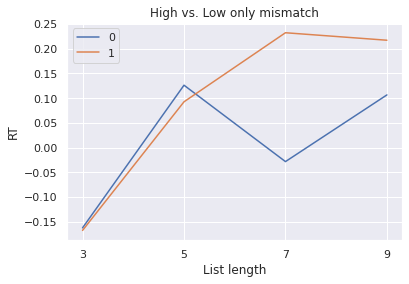

In [112]:
pl.figure()
high_low = only_mismatch.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low only mismatch');

## Individual distributions of RT per subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


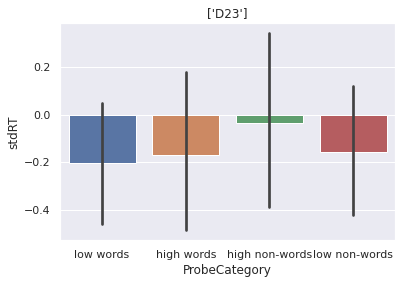

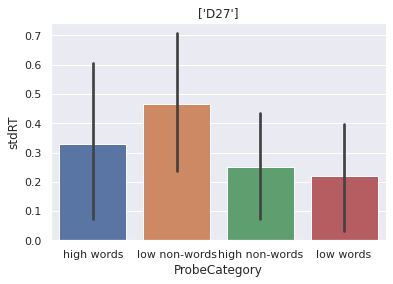

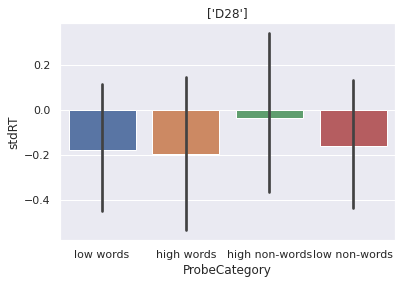

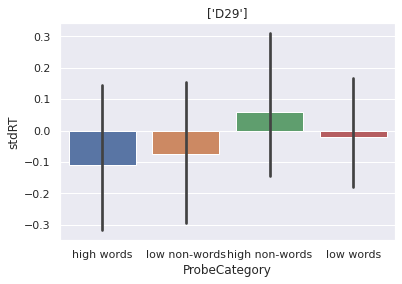

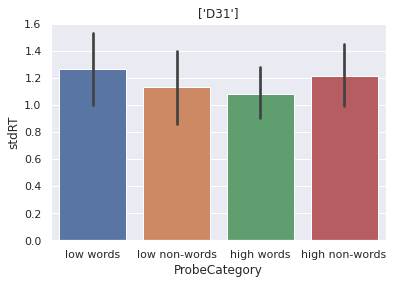

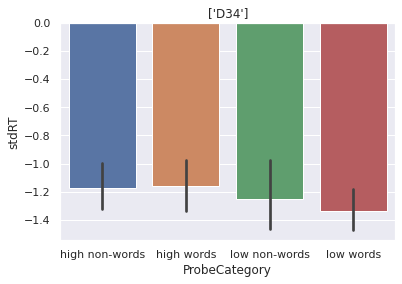

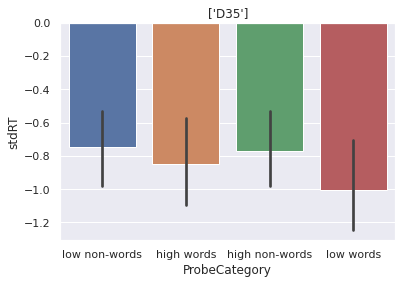

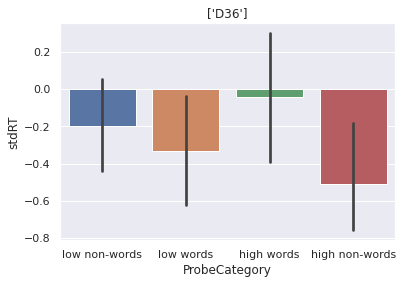

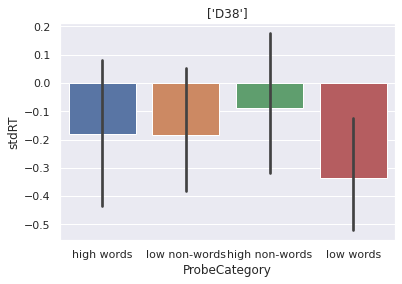

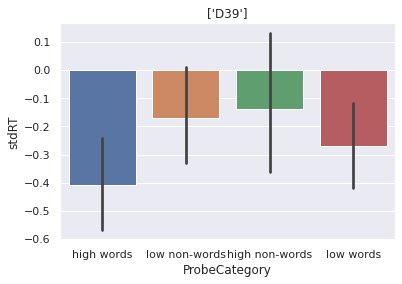

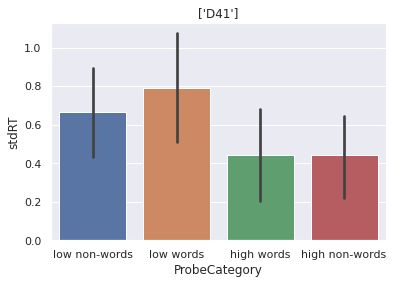

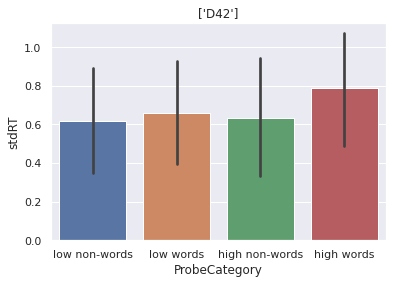

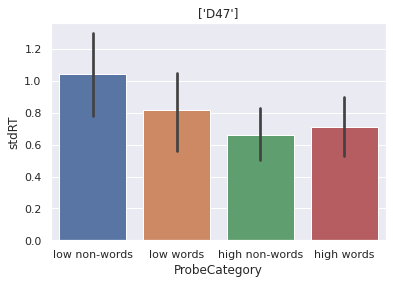

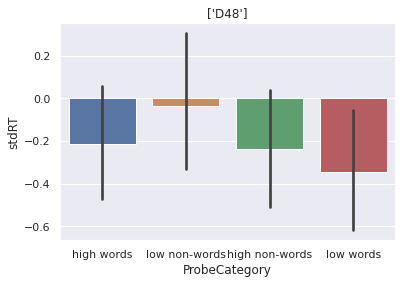

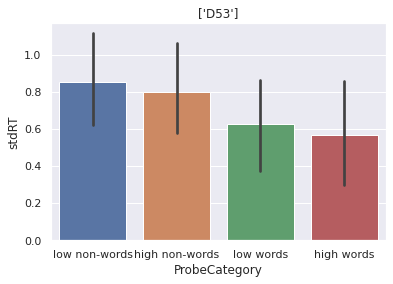

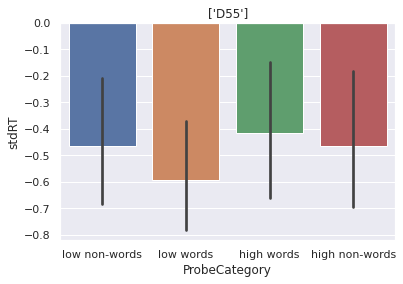

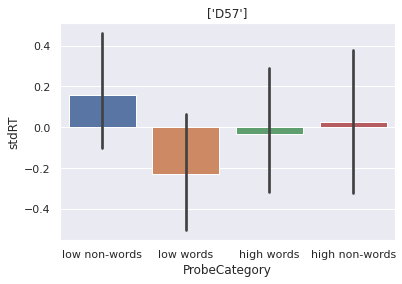

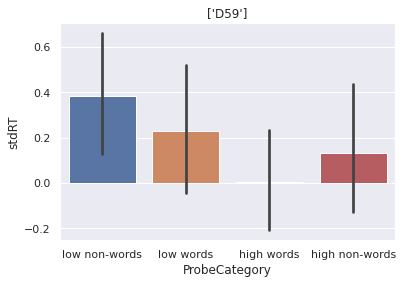

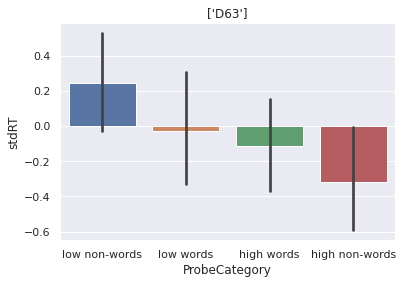

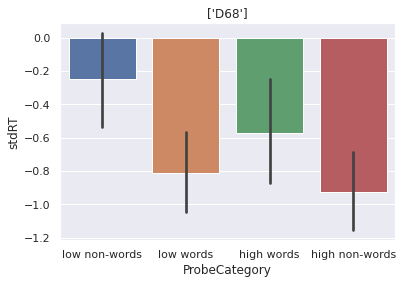

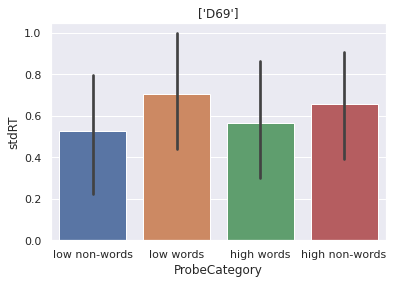

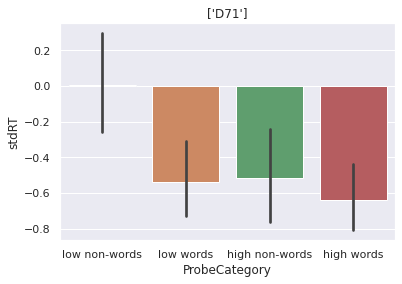

In [113]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.barplot(x = 'ProbeCategory', y = 'stdRT', data = subset,
      estimator = lambda x: sum(x)/len(x))
  pl.title(subset.Subject.unique())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


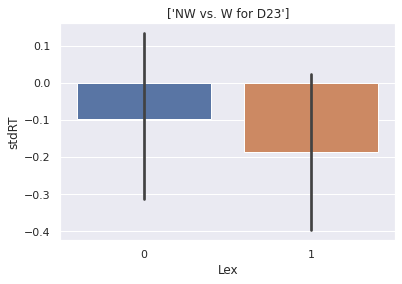

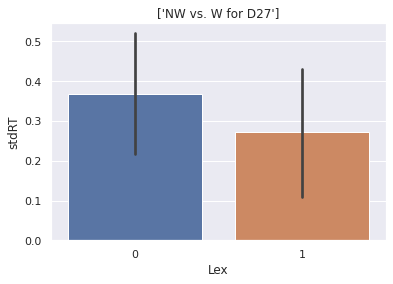

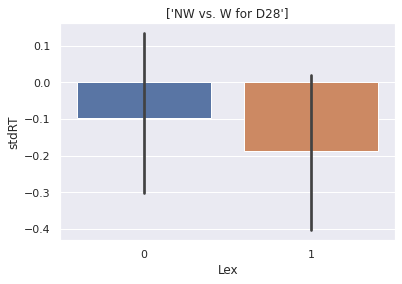

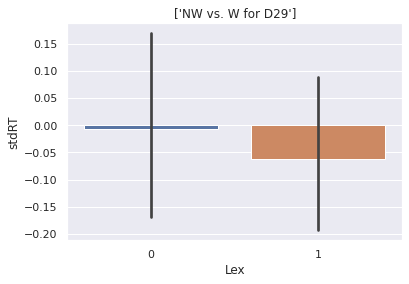

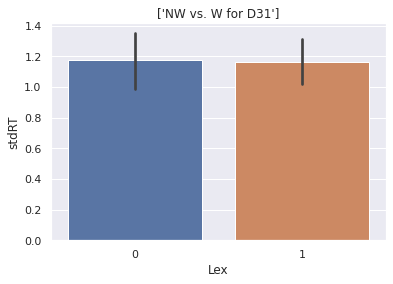

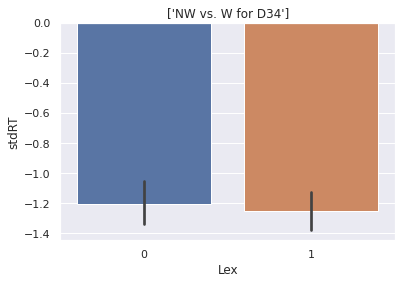

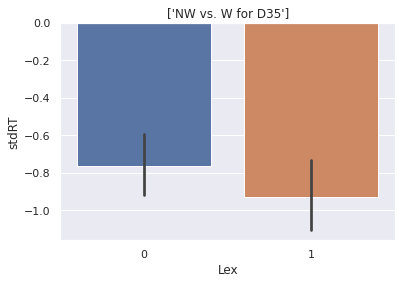

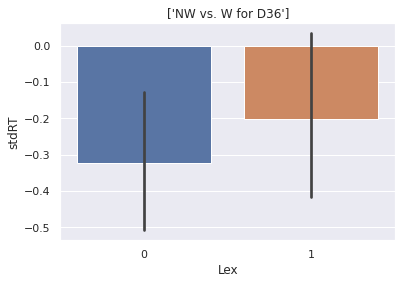

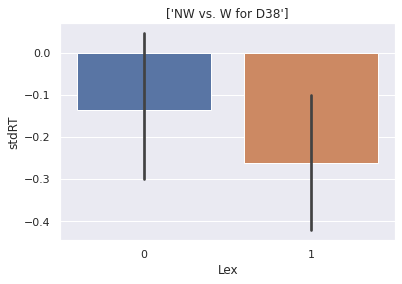

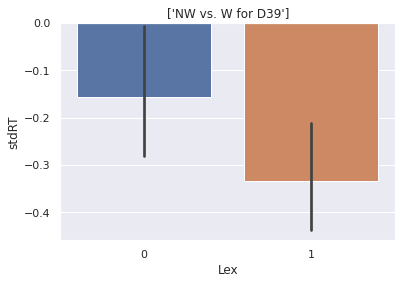

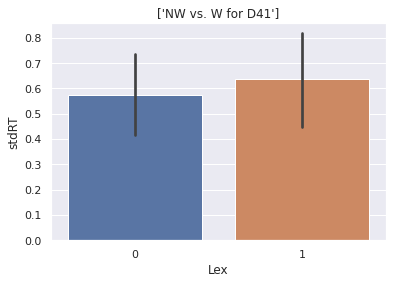

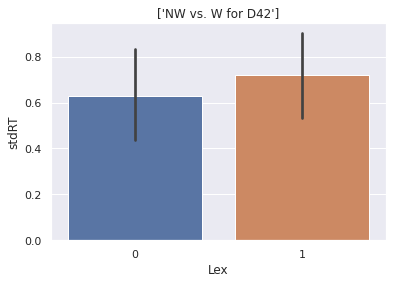

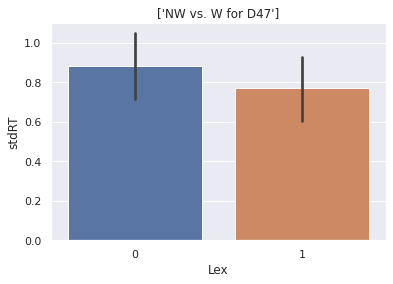

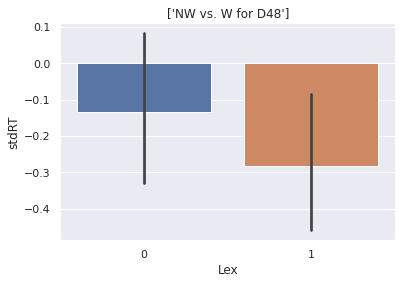

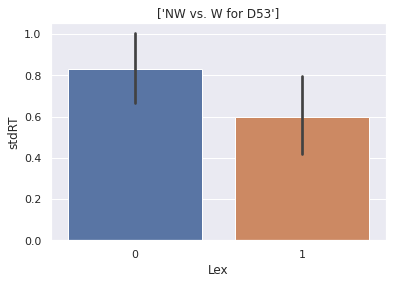

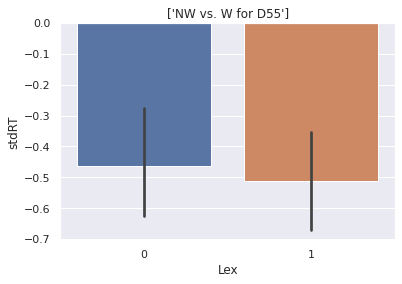

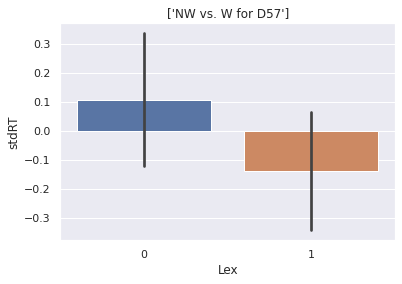

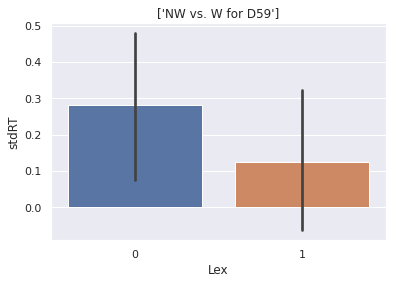

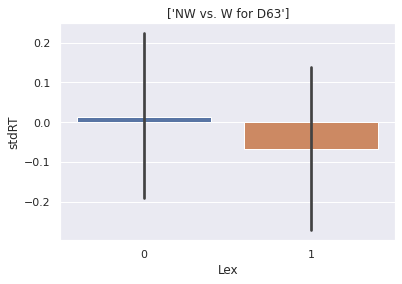

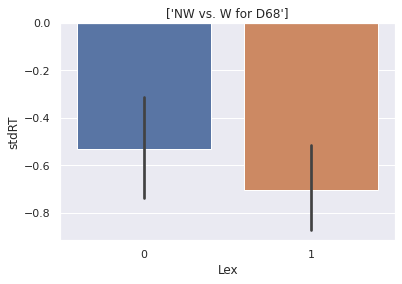

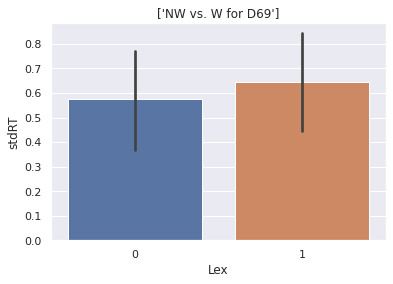

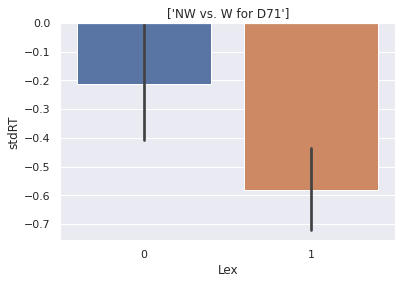

In [114]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'Lex', y = 'stdRT', data = subset, 
              estimator = lambda x: sum(x)/len(x));
  pl.title('NW vs. W for ' + subset.Subject.unique());

In [115]:
sample = ieeg_no_outliers[ieeg_no_outliers['Subject'] == 'D27']
sample = sample[[
                 'Lex', 'ReactionTime', 'ProbeType'
]]

In [116]:
x = sample[(sample['Lex'] == 1) & (sample['ProbeType'] == 2)]
y = sample[(sample['Lex'] == 0) & (sample['ProbeType'] == 2)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 0.03758369,        nan]), pvalue=array([0.        , 0.97011691,        nan]))

In [117]:
sample = ieeg_no_outliers[ieeg_no_outliers['Subject'] == 'D28']
sample = sample[[
                 'ProbeCategory', 'ProbeType', 'ReactionTime'
]]

In [118]:
x = sample[sample['ProbeCategory'] == 'low words']['ReactionTime'].values
y = sample[sample['ProbeCategory'] == 'low non-words']['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.08954746994919191, pvalue=0.9288870409442719)

In [119]:
x = sample[sample['ProbeCategory'] == 'high words']['ReactionTime'].values
y = sample[sample['ProbeCategory'] == 'high non-words']['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.6463836517261341, pvalue=0.5201753542669311)

In [120]:
x = sample[sample['ProbeCategory'] == 'low words']['ReactionTime'].values
y = sample[sample['ProbeCategory'] == 'high words']['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.07505676418722657, pvalue=0.9403902641924482)

In [121]:
x = sample[sample['ProbeCategory'] == 'low non-words']['ReactionTime'].values
y = sample[sample['ProbeCategory'] == 'high non-words']['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.5427773305398537, pvalue=0.5890403049107804)

In [122]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.5186344747142986, pvalue=0.6069873288045934)

In [123]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.2348860564891877, pvalue=0.8157116282504082)

In [124]:
x = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.14131137266871863, pvalue=0.8884694181282206)

In [125]:
x = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.7186814148304864, pvalue=0.47746612989848125)

In [126]:
x = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.19773397937750076, pvalue=0.8444987589934712)

In [127]:
x = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.42877971568488465, pvalue=0.6708833002964261)

In [128]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 2)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-0.5138955319045371, pvalue=0.6107343364452336)

In [129]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
y = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 1)]['ReactionTime'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.5558437199666344, pvalue=0.5821936309929308)

Plotting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


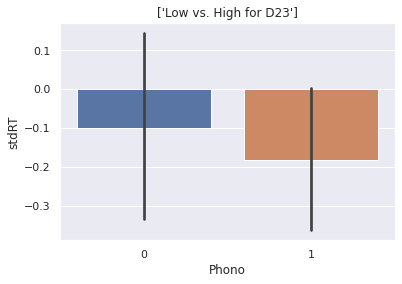

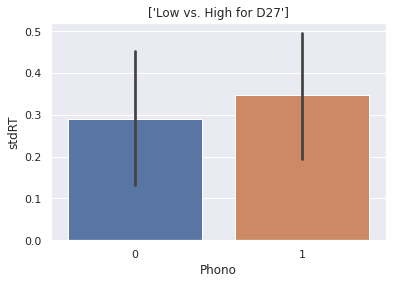

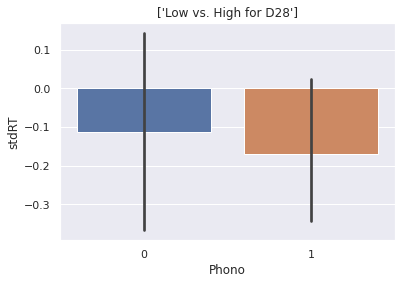

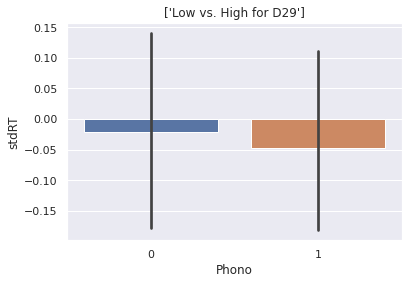

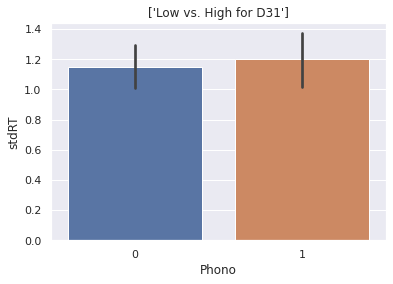

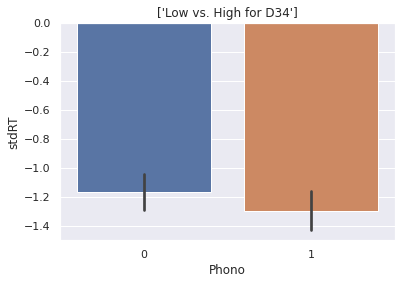

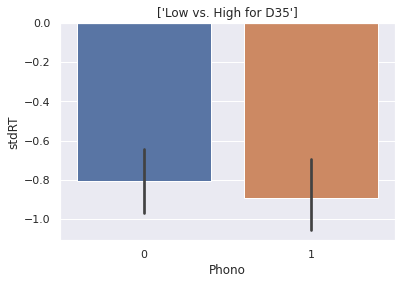

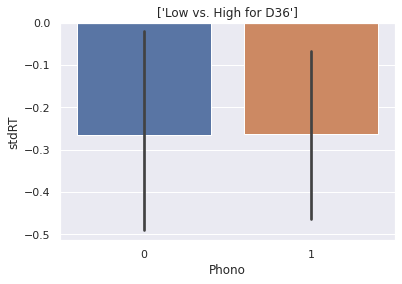

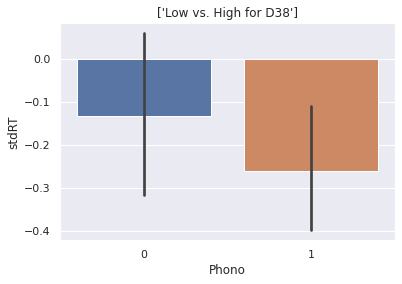

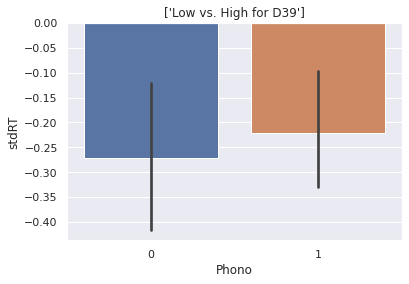

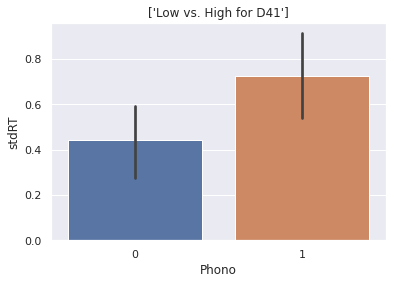

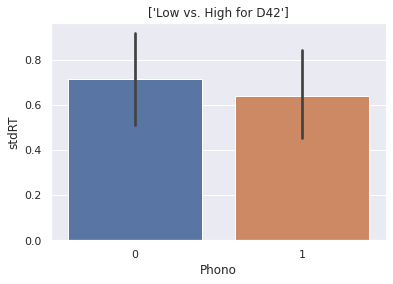

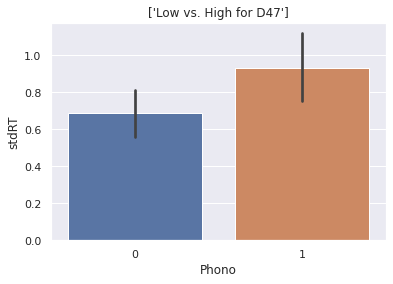

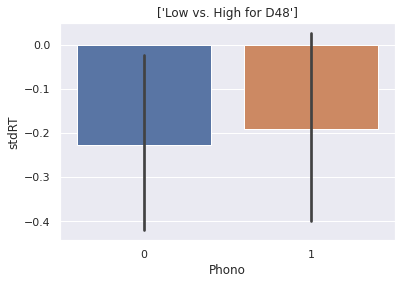

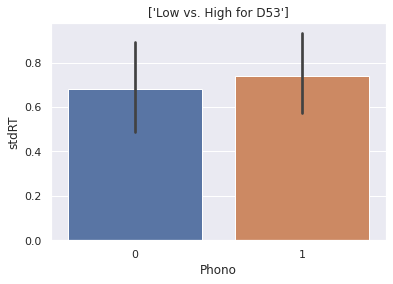

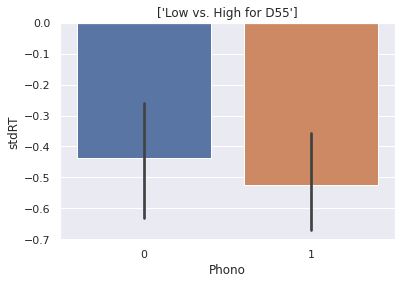

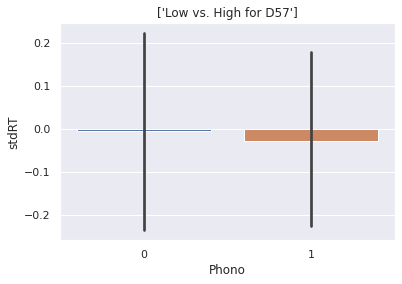

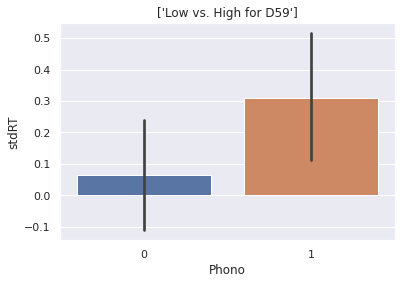

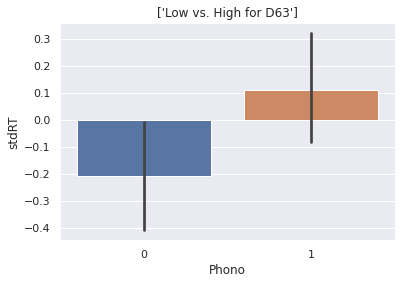

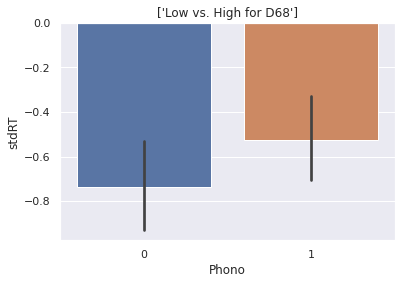

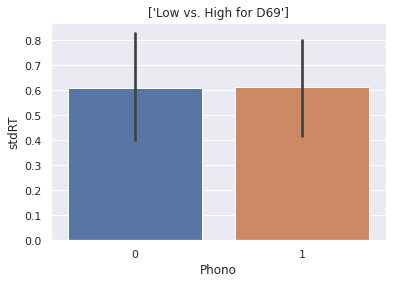

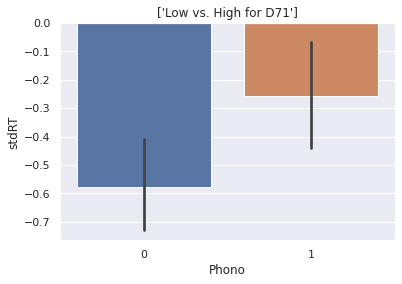

In [130]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'Phono', y = 'stdRT', data = subset, 
              estimator = lambda x: sum(x)/len(x));
  pl.title('Low vs. High for ' + subset.Subject.unique());

In [131]:
sample = ieeg_no_outliers[ieeg_no_outliers['Subject'] == 'D41']
sample = sample[[
                 'Phono', 'ReactionTime', 'ProbeType'
]]

In [132]:
x = sample[(sample['Phono'] == 1) & (sample['ProbeType'] == 2)]
y = sample[(sample['Phono'] == 0) & (sample['ProbeType'] == 2)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 1.79240791,        nan]), pvalue=array([0.        , 0.07761471,        nan]))

## **Only for correct responses**

In [133]:
correct = ieeg_no_outliers[ieeg_no_outliers['RespCorrect'] == 1]
incorrect = ieeg_no_outliers[ieeg_no_outliers['RespCorrect'] == 0]

In [134]:
correct.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length,stdRT,Lex,Phono
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[29, 25, 30]",1,3,-0.842083,1,1
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7,0.720888,1,0
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7,-0.232119,0,0
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9,1.231184,1,1
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5,1.823783,1,0


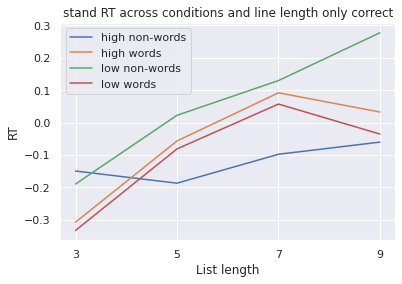

In [135]:
subset = correct.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('stand RT across conditions and line length only correct'); 

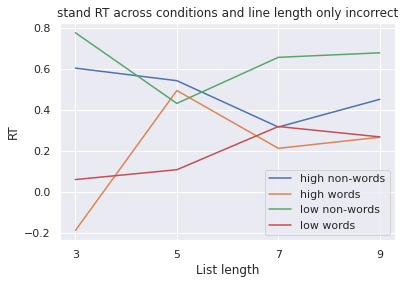

In [136]:
subset = incorrect.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('stand RT across conditions and line length only incorrect');  

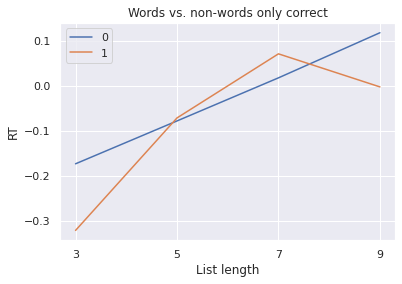

In [137]:
pl.figure()
words_nonwords = correct.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only correct');  

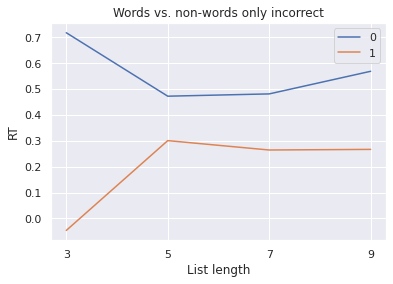

In [138]:
pl.figure()
words_nonwords = incorrect.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only incorrect'); 

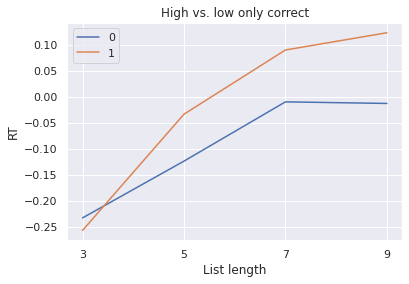

In [139]:
pl.figure()
words_nonwords = correct.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Phono.unique():
  x = words_nonwords[words_nonwords['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Phono.unique())
pl.title('High vs. low only correct'); 

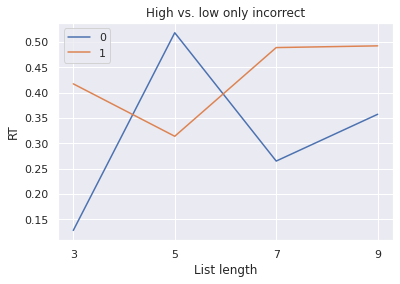

In [140]:
pl.figure()
words_nonwords = incorrect.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Phono.unique():
  x = words_nonwords[words_nonwords['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Phono.unique())
pl.title('High vs. low only incorrect'); 

## Saving result

In [141]:
# saving result
ieeg_no_outliers.to_csv(
    Path(working_path).joinpath('ieeg_no_outliers.csv')
)